### Install

In [ ]:
!pip install git+https://github.com/mattjj/pybasicbayes
#!git clone https://github.com/WorldsEndDunce/pyhawkes
!git clone https://github.com/slinderman/pyhawkes
%cd pyhawkes
!pip install -e .

### Modify `models.py` at L791:

```
    def generate(self, keep=True, T=100, print_interval=25, verbose=False, stim_idx=None, R_init=None):
        """
        Generate a new data set with the sampled parameters

        :param keep: If True, add the generated data to the data list.
        :param T:    Number of time bins to simulate.
        :param stim: list of indices to trigger events on initialization.
        :param R_init: used to continue simulating from end of previous generate.
        :return: A TxK
        """
        assert isinstance(T, int), "T must be an integer number of time bins"

        # Test stability
        self.check_stability()

        # Initialize the output
        S = np.zeros((T, self.K))

        # Precompute the impulse responses (LxKxK array)
        G = np.tensordot(self.basis.basis, self.impulse_model.g, axes=([1], [2]))
        L = self.basis.L
        assert G.shape == (L,self.K, self.K)
        H = self.weight_model.W_effective[None,:,:] * G

        # Transpose H so that it is faster for tensor mult
        H = np.transpose(H, axes=[0,2,1])

        # Compute the rate matrix R
        R = np.zeros((T+L, self.K))

        # Add the background rate
        R += self.bias_model.lambda0[None,:]

        if R_init is not None:
          R[:self.dt_max+1,:] = R_init

        iterator = progprint_xrange(T, perline=print_interval) if verbose else range(T)

        if stim_idx is not None: 
          S[0,stim_idx] = 1

        # Iterate over time bins
```

## Work in Progress

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pyhawkes.models import DiscreteTimeNetworkHawkesModelSpikeAndSlab

In [ ]:
np.random.seed(0)

# Generate synthetic data via true_model

K      = 3    # Number of nodes
T      = 100  # Number of time bins to simulate
dt_max = 10   # Number of future time bins an event can influence
p      = 0.5  # Sparsity of network

network_hypers = {"p": p, "allow_self_connections": False}

true_model = DiscreteTimeNetworkHawkesModelSpikeAndSlab(
    K=K,
    dt_max=dt_max,
    network_hypers=network_hypers,
    # impulse=Exponential, impulse_hypers=?, basis=?
    )
assert true_model.check_stability(verbose=True)

Max eigenvalue:  0.25215290122848


In [ ]:
true_model.A*true_model.W

array([[0.        , 0.15070069, 0.28147593],
       [0.19244144, 0.        , 0.        ],
       [0.07810051, 0.05863785, 0.        ]])

[0.07958745 0.12559308 0.09232231]
(11, 3, 3)


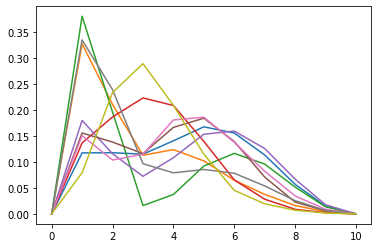

In [ ]:
print(true_model.lambda0)
print(true_model.impulses.shape)
for i in range(K):
  for j in range(K):
    plt.plot(true_model.impulses[:, i, j])

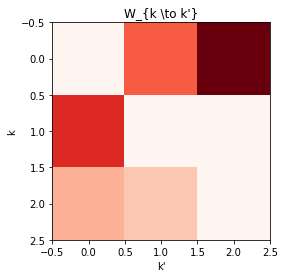

In [ ]:
true_model.plot_adjacency_matrix();

In [ ]:
# Sample from true_model
S, R, R_next = true_model.generate(T=T, keep=True, print_interval=50)

print(S.shape, R.shape, R_next.shape)

(100, 3) (100, 3) (11, 3)


/content/pyhawkes/pyhawkes/internals/parents.py:76: UserWarning: Failed to import gslrandom for parallel multinomial sampling. Defaulting to pure python instead. This will have a significant impact on performance. To install gslrandom, see https://github.com/slinderman/gslrandom
  warn("Failed to import gslrandom for parallel multinomial sampling. "


In [ ]:
true_model.data_list # Main dataset

In [ ]:
# Create a test spike and slab model
test_model = DiscreteTimeNetworkHawkesModelSpikeAndSlab(
    K=K, dt_max=dt_max,
    network_hypers=network_hypers)

test_model.add_data(S)

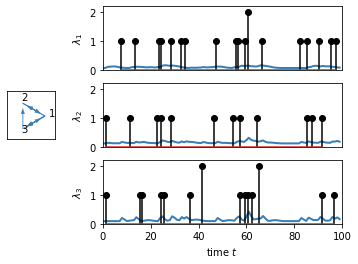

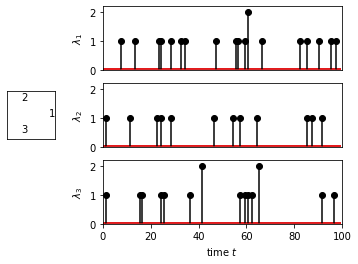

In [ ]:
plt.ion()
true_figure, _ = true_model.plot(color="#377eb8", T_slice=(0,T))
# Initialize plots
test_figure, test_handles = test_model.plot(color="#e41a1c", T_slice=(0,T))

Gibbs iteration  0
Gibbs iteration  10
Gibbs iteration  20
Gibbs iteration  30
Gibbs iteration  40
Gibbs iteration  50
Gibbs iteration  60
Gibbs iteration  70
Gibbs iteration  80
Gibbs iteration  90


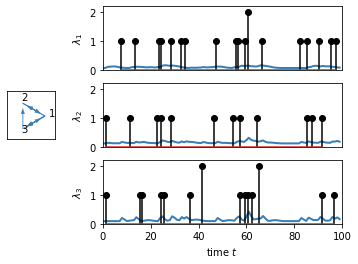

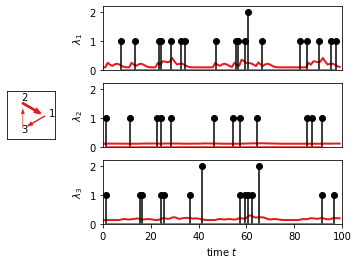

In [ ]:
# Fit the test model with Gibbs sampling
N_samples = 100
samples = []
lps = []
for itr in range(N_samples):
    if itr%10 == 0: print("Gibbs iteration ", itr)
    test_model.resample_model()
    lps.append(test_model.log_probability())
    samples.append(test_model.copy_sample())

    # Update plots
    #test_model.plot(handles=test_handles)

true_model.plot(color="#377eb8", T_slice=(0,T))
test_model.plot(color="#e41a1c", T_slice=(0,T));

In [ ]:
#========= Probing function =========
# input(s): Matrix of SDs of weights
# Sum rows, pick row index with largest value
# New stimulation vector with 1 to stimulate row (test for one for now)
# true_model.generate(100, keep=True, print_interval=50, v)
# Use test_model.add_data(v)?
# return nothing

In [ ]:
def analyze_samples(true_model, samples, lps):

  N_samples = len(samples)

  # Compute sample statistics for second half of samples
  A_samples       = np.array([s.weight_model.A     for s in samples])
  W_samples       = np.array([s.weight_model.W     for s in samples])
  W_eff_samples   = A_samples*W_samples
  lps             = np.array(lps)

  offset = N_samples // 2
  W_eff_mean      = W_eff_samples[offset:, ...].mean(axis=0)
  W_eff_std       = W_eff_samples[offset:, ...].std(axis=0)

  stim_idx = np.argmax(W_eff_std.sum(axis=1))

  error = true_model.W_effective - W_eff_mean

  return np.linalg.norm(error), stim_idx

In [ ]:
# Generate synthetic data via true_model

K      = 10    # Number of nodes
T      = 50    # Number of time bins to simulate
dt_max = 10    # Number of future time bins an event can influence
p      = 0.25   # Sparsity of network

network_hypers = {"p": p, "allow_self_connections": False}

def training(mode=["passive", "random", "active"][0]):

  np.random.seed(0)
  
  true_model = DiscreteTimeNetworkHawkesModelSpikeAndSlab(
      K=K,
      dt_max=dt_max,
      network_hypers=network_hypers,
      )
  assert true_model.check_stability(verbose=True)

  # Sample from true_model
  S, R, R_next = true_model.generate(T=T, keep=True, print_interval=50)

  # Create a test spike and slab model
  test_model = DiscreteTimeNetworkHawkesModelSpikeAndSlab(
      K=K, dt_max=dt_max,
      network_hypers=network_hypers)

  test_model.add_data(S)

  T_total = 1000
  errors = []
  for i in range(T_total//T):
    print("T: {}/{}".format(T*(i+1),T_total))
    # Fit the test model with Gibbs sampling
    N_samples = 100
    samples = []
    lps = []
    for itr in range(N_samples):
        test_model.resample_model()
        lps.append(test_model.log_probability())
        samples.append(test_model.copy_sample())
  
    e, stim_idx = analyze_samples(true_model, samples, lps)
    errors.append((T*(i+1),e))

    if mode == "passive":
      stim_idx = None
    elif mode == "random":
      stim_idx = np.random.randint(K)
    
    S, R, R_next = true_model.generate(T=T, stim_idx=stim_idx, R_init=R_next)
    test_model.add_data(S)
  
  true_model.plot(color="#377eb8", T_slice=(0,T))
  test_model.plot(color="#e41a1c", T_slice=(0,T))
  plt.show()

  return np.array(errors)

Max eigenvalue:  0.5259221389622573
T: 50/1000
T: 100/1000
T: 150/1000
T: 200/1000
T: 250/1000
T: 300/1000
T: 350/1000
T: 400/1000
T: 450/1000
T: 500/1000
T: 550/1000
T: 600/1000
T: 650/1000
T: 700/1000
T: 750/1000
T: 800/1000
T: 850/1000
T: 900/1000
T: 950/1000
T: 1000/1000


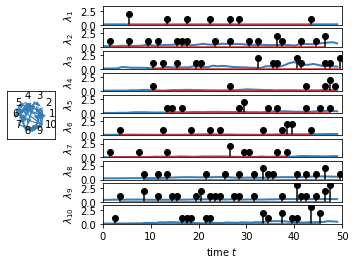

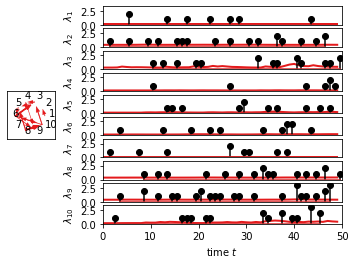

Max eigenvalue:  0.5259221389622573
T: 50/1000
T: 100/1000
T: 150/1000
T: 200/1000
T: 250/1000
T: 300/1000
T: 350/1000
T: 400/1000
T: 450/1000
T: 500/1000
T: 550/1000
T: 600/1000
T: 650/1000
T: 700/1000
T: 750/1000
T: 800/1000
T: 850/1000
T: 900/1000
T: 950/1000
T: 1000/1000


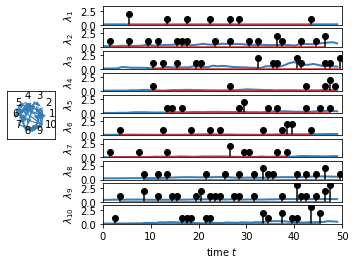

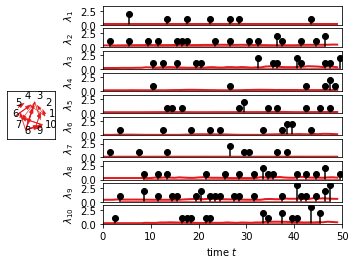

Max eigenvalue:  0.5259221389622573
T: 50/1000
T: 100/1000
T: 150/1000
T: 200/1000
T: 250/1000
T: 300/1000
T: 350/1000
T: 400/1000
T: 450/1000
T: 500/1000
T: 550/1000
T: 600/1000
T: 650/1000
T: 700/1000
T: 750/1000
T: 800/1000
T: 850/1000
T: 900/1000
T: 950/1000
T: 1000/1000


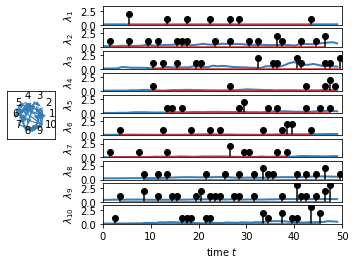

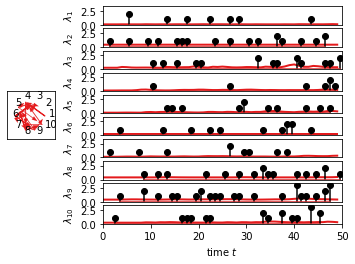

In [ ]:
passive = training("passive")
random = training("random")
active = training("active")

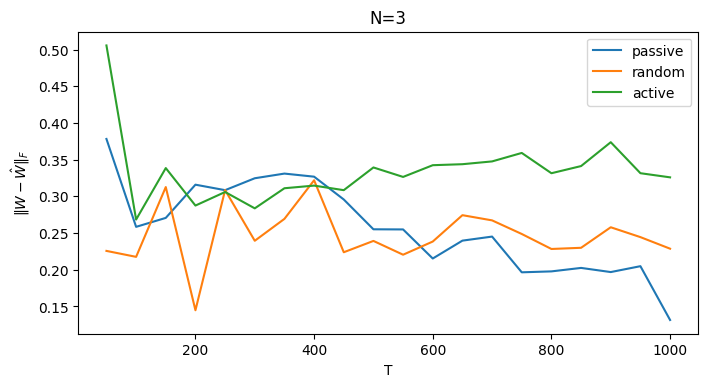

In [ ]:
plt.figure(figsize=(8,4),dpi=100)
plt.plot(passive[:,0], passive[:,1], label="passive")
plt.plot(random[:,0], random[:,1], label="random")
plt.plot(active[:,0], active[:,1], label="active")
plt.title("N={}".format(K))
plt.xlabel("T")
plt.ylabel("${\|W-\hat{W}\|}_F$")
plt.legend()
plt.show()

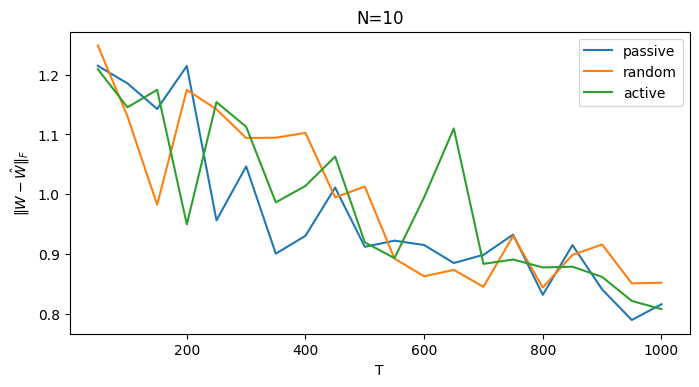

In [ ]:
plt.figure(figsize=(8,4),dpi=100)
plt.plot(passive[:,0], passive[:,1], label="passive")
plt.plot(random[:,0], random[:,1], label="random")
plt.plot(active[:,0], active[:,1], label="active")
plt.title("N={}".format(K))
plt.xlabel("T")
plt.ylabel("${\|W-\hat{W}\|}_F$")
plt.legend()
plt.show()

In [ ]:
# ====== Brian's code ======
# 
from ssl import ALERT_DESCRIPTION_DECODE_ERROR
def analyze_samples(true_model, samples, lps):
    
    from sklearn.metrics import roc_auc_score
    
    N_samples = len(samples)

    # Compute sample statistics for second half of samples
    A_samples       = np.array([s.weight_model.A     for s in samples])
    W_samples       = np.array([s.weight_model.W     for s in samples])
    #lps             = np.array(lps)

    offset = N_samples // 2
    A_mean       = A_samples[offset:, ...].mean(axis=0)
    W_mean       = W_samples[offset:, ...].mean(axis=0)

    W_std         = (A_samples[offset:, ...] * W_samples[offset:, ...]).std(axis=0)
    print(W_std)
    # TODO: Take SD too
    # find smallest row
    max_std = 0
    max_std_index = 0
    for i in range(W_std.shape[0]):
      row_std = W_std[i].sum()
      if row_std > max_std:
        max_std = row_std
        max_std_index = i

    v = np.zeros(W_std.shape[0])
    v[max_std_index] = 1 

    test_model.generate(T=T, keep=True, print_interval=50, v=v)
    print(max_std)
    print(N_samples)
    for itr in range(N_samples):
      print("Gibbs iteration ", itr)
      test_model.resample_model()
      lps.append(test_model.log_probability())
      samples.append(test_model.copy_sample())

    N_samples = len(samples)
    A_samples       = np.array([s.weight_model.A     for s in samples])
    W_samples       = np.array([s.weight_model.W     for s in samples])
    lps             = np.array(lps)

    offset = N_samples // 2
    A_mean       = A_samples[offset:, ...].mean(axis=0)
    W_mean       = W_samples[offset:, ...].mean(axis=0)

    W_std         = (A_samples[offset:, ...] * W_samples[offset:, ...]).std(axis=0)

    while max_std > 0.15:
      for i in range(W_std.shape[0]):
        row_std = W_std[i].sum()
        if row_std > max_std:
          max_std = row_std
          max_std_index = i
      v = np.zeros(W_std.shape[0])
      v[max_std_index] = 1 

      test_model.generate(T=T, keep=True, print_interval=50, v=v)

      for itr in range(N_samples):
        print("Gibbs iteration ", itr)
        test_model.resample_model()
        lps.append(test_model.log_probability())
        samples.append(test_model.copy_sample())

    max_std = 0
    max_std_index = 0
    for i in range(W_std.shape[0]):
      row_std = W_std[i].sum()
      if row_std > max_std:
        max_std = row_std
        max_std_index = i

    print(max_std)
    
    # N_samples = len(samples)
    # A_samples       = np.array([s.weight_model.A     for s in samples])
    # W_samples       = np.array([s.weight_model.W     for s in samples])

    # offset = N_samples // 2
    # A_mean       = A_samples[offset:, ...].mean(axis=0)
    # W_mean       = W_samples[offset:, ...].mean(axis=0)

    # W_std         = (A_samples[offset:, ...] * W_samples[offset:, ...]).std(axis=0)

    # v = np.zeros(W_std.shape[0])
    # v[max_std_index] = 1 

    # test_model.generate(T=T, keep=True, print_interval=50, v=v)

    plt.figure()
    plt.plot(np.arange(N_samples), lps, 'k')
    plt.xlabel("Iteration")
    plt.ylabel("Log probability")
    plt.show()

    # Compute the link prediction accuracy curves
    auc_A_mean = roc_auc_score(true_model.weight_model.A.ravel(),
                               A_mean.ravel())
    auc_W_mean = roc_auc_score(true_model.weight_model.A.ravel(),
                               W_mean.ravel())

    aucs = []
    for A in A_samples:
        aucs.append(roc_auc_score(true_model.weight_model.A.ravel(), A.ravel()))

    plt.figure()
    plt.plot(aucs, '-r')
    plt.plot(auc_A_mean * np.ones_like(aucs), '--r')
    plt.plot(auc_W_mean * np.ones_like(aucs), '--b')
    plt.xlabel("Iteration")
    plt.ylabel("Link prediction AUC")
    plt.show()

    plt.ioff()
    plt.show()
    print(W_mean * A_mean)
    print(W_std)

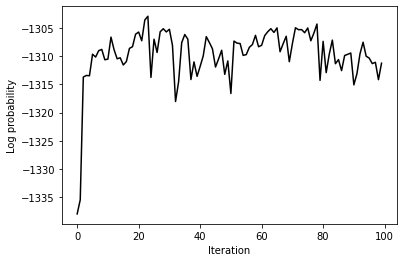

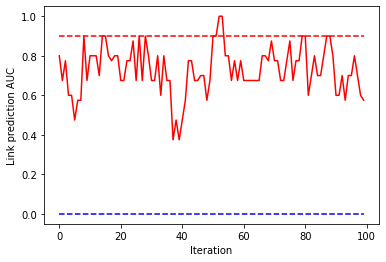

[[0.         0.14916683 0.13460428]
 [0.17681925 0.         0.10478479]
 [0.05520138 0.04539969 0.        ]]
[[0.         0.08962362 0.06729109]
 [0.11638961 0.         0.07095322]
 [0.04480484 0.02693515 0.        ]]


In [ ]:
# Analyze the samples
analyze_samples(true_model, samples, lps)

In [ ]:
true_model.weight_model.W_effective

array([[0.        , 0.15070069, 0.28147593],
       [0.19244144, 0.        , 0.        ],
       [0.07810051, 0.05863785, 0.        ]])

## Data Generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_network(A, W, vmax=None):
    """
    Plot an image of the network
    :param A:
    :param W:
    :return:
    """
    plt.figure()

    # Compute vmax
    if vmax is None:
        vmax = np.amax(A*W)

    plt.imshow(A*W, interpolation="none", cmap='gray', vmin=0, vmax=vmax)
    plt.ylabel('k')
    plt.xlabel('k\'')
    plt.title('W_{k \\to k\'}')
    plt.colorbar()
    plt.show()

Setting seed to  3848328624


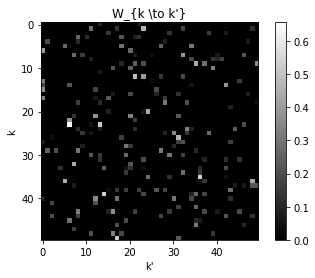

Saving output to  data/synthetic/synthetic_K50_C1_T100000.pkl.gz
Saving output to  data/synthetic/synthetic_test_K50_C1_T1000.pkl.gz


In [ ]:
import pickle
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pyhawkes.models import DiscreteTimeNetworkHawkesModelSpikeAndSlab
# from pyhawkes.plotting.plotting import plot_network  # Doesn't exist

def generate_synthetic_data(seed=None):
    """
    Create a discrete time Hawkes model and generate from it.
    :return:
    """
    if seed is None:
        seed = np.random.randint(2**32)

    print("Setting seed to ", seed)
    np.random.seed(seed)

    # Create a true model
    # Larger v (weight scale) implies smaller weights

    T_test=1000

    # Debugging network:
    # C = 1
    # K = 4
    # T = 1000
    # dt = 1.0
    # B = 3
    # p = 0.5
    # kappa = 3.0
    # v = kappa * 5.0
    # c = np.zeros(K, dtype=np.int)

    # Small network:
    # Seed: 1957629166
    # C = 4
    # K = 20
    # T = 10000
    # dt = 1.0
    # B = 3
    # kappa = 3.0
    # p = 0.9 * np.eye(C) + 0.05 * (1-np.eye(C))
    # v = kappa * (5.0 * np.eye(C) + 25.0 * (1-np.eye(C)))
    # c = np.arange(C).repeat((K // C))

    # Medium network:
    # Seed: 2723361959
    # C = 5
    # K = 50
    # T = 100000
    # dt = 1.0
    # B = 3
    # kappa = 3.0
    # p = 0.75 * np.eye(C) + 0.05 * (1-np.eye(C))
    # v = kappa * (9 * np.eye(C) + 25.0 * (1-np.eye(C)))
    # c = np.arange(C).repeat((K // C))

    # Medium netowrk 2:
    # Seed = 3848328624
    # C = 5
    # K = 50
    # T = 100000
    # dt = 1.0
    # B = 3
    # kappa = 2.0
    # c = np.arange(C).repeat((K // C))
    # p = 0.4 * np.eye(C) + 0.01 * (1-np.eye(C))
    # v = kappa * (5 * np.eye(C) + 5.0 * (1-np.eye(C)))

    # Medium netowrk, one cluster
    # Seed: 3848328624
    C = 1
    K = 50
    T = 100000
    dt = 1.0
    B = 3
    p = 0.08
    kappa = 3.0
    v = kappa * 5.0
    c = np.zeros(K, dtype=int)

    # Large network:
    # Seed = 2467634490
    # C = 5
    # K = 100
    # T = 100000
    # dt = 1.0
    # B = 3
    # kappa = 3.0
    # p = 0.4 * np.eye(C) + 0.025 * (1-np.eye(C))
    # v = kappa * (10 * np.eye(C) + 25.0 * (1-np.eye(C)))
    # c = np.arange(C).repeat((K // C))

    # Large network 2:
    # Seed =
    # C = 10
    # K = 100
    # T = 100000
    # dt = 1.0
    # B = 3
    # kappa = 3.0
    # p = 0.75 * np.eye(C) + 0.05 * (1-np.eye(C))
    # v = kappa * (9 * np.eye(C) + 25.0 * (1-np.eye(C)))
    # c = np.arange(C).repeat((K // C))

    # Extra large network:
    # Seed: 2327447870
    # C = 20
    # K = 1000
    # T = 100000
    # dt = 1.0
    # B = 3
    # kappa = 3.0
    # p = 0.25 * np.eye(C) + 0.0025 * (1-np.eye(C))
    # v = kappa * (15 * np.eye(C) + 30.0 * (1-np.eye(C)))
    # c = np.arange(C).repeat((K // C))


    # Create the model with these parameters
    network_hypers = {'C': C, 'kappa': kappa, 'c': c, 'p': p, 'v': v}

    # Create a simple network
    from pyhawkes.internals.network import ErdosRenyiFixedSparsity
    network = ErdosRenyiFixedSparsity(K, p, kappa, v=v)

    true_model = DiscreteTimeNetworkHawkesModelSpikeAndSlab(K=K, dt=dt, B=B,
                                                            network=network)

    assert true_model.check_stability()

    # Plot the true network
    plt.ion()
    plot_network(true_model.weight_model.A,
                 true_model.weight_model.W)
    plt.pause(0.001)

    # Sample from the true model
    S,R = true_model.generate(T=T, keep=False, print_interval=50)

    # Pickle and save the data
    out_dir  = os.path.join('data', "synthetic")
    out_name = 'synthetic_K%d_C%d_T%d.pkl.gz' % (K,C,T)
    out_path = os.path.join(out_dir, out_name)
    with gzip.open(out_path, 'w') as f:
        print("Saving output to ", out_path)
        pickle.dump((S, true_model), f, protocol=-1)

    # Sample test data
    S_test,_ = true_model.generate(T=T_test, keep=False)

    # Pickle and save the data
    out_dir  = os.path.join('data', "synthetic")
    out_name = 'synthetic_test_K%d_C%d_T%d.pkl.gz' % (K,C,T_test)
    out_path = os.path.join(out_dir, out_name)
    with gzip.open(out_path, 'w') as f:
        print("Saving output to ", out_path)
        pickle.dump((S_test, true_model), f, protocol=-1)


# demo(2203329564)
generate_synthetic_data(3848328624)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, \
    HawkesSumExpKern

end_time = 1000
n_realizations = 10

decays = [.5, 2., 6.]

# baseline intensity
baseline = [0.1, 0.9]

# shape=(n_nodes, n_nodes, n_decays)
adjacency = [[[0, .1, .4], [.2, 0., .2]],
             [[0, 0, 0], [.6, .3, 0]]]

hawkes_exp_kernels = SimuHawkesSumExpKernels(
    adjacency=adjacency, decays=decays, baseline=baseline,
    end_time=end_time, verbose=False, seed=1039)

multi = SimuHawkesMulti(hawkes_exp_kernels, n_simulations=n_realizations)

multi.end_time = [(i + 1) / 10 * end_time for i in range(n_realizations)]
multi.simulate()

learner = HawkesSumExpKern(decays, penalty='elasticnet',
                           elastic_net_ratio=0.8)
learner.fit(multi.timestamps)

fig = plot_hawkes_kernels(learner, hawkes=hawkes_exp_kernels, show=False)

for ax in fig.axes:
    ax.set_ylim([0., 1.])